In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, auc, roc_curve
import itertools
import yaml
import os
import numpy as np
from statistics import mean

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Matriz de Confusión',
                          cmap=plt.cm.Blues):
    """
    Esta función imprime y plotea la matriz de confusión.
    La normalización se puede aplicar configurando `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.tight_layout()

In [3]:
path = 'Mode_train-Model_random_forest-TrainWw_480-TrainPd_1-TradingStgy_macd_strategy-PeriodsFwTg_5-SL_15-TP_30-UseDaysClose_False'
orders = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'orders.csv'))
wallet = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'wallet.csv'))
true_values = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'truevals.csv'))
predictions = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'preds.csv'))

In [4]:
orders

,id,ticker,operation_type,open_time,close_time,open_price,close_price,profit,stop_loss,take_profit,units,profit_in_pips,comment
0,2f8d97a3-188d-11ef-8b50-c73def676cf0,AUDUSD,sell,2023-07-03 08:00:00,2023-07-03 16:00:00,0.66627,0.66767,-9.33380,0.66777,0.66327,6667,-0.00140,closed for stop loss
1,2f8e2c7e-188d-11ef-8898-c73def676cf0,USDJPY,buy,2023-07-03 08:00:00,2023-07-03 11:00:00,144.57800,144.71400,9.11200,144.42800,144.87800,67,0.13600,closed for take profit
2,35d2ec02-188d-11ef-baa1-c73def676cf0,USDJPY,buy,2023-07-03 12:00:00,2023-07-03 14:00:00,144.59200,144.85700,17.75500,144.44200,144.89200,67,0.26500,closed for take profit
3,3c685a02-188d-11ef-a8fa-c73def676cf0,USDJPY,buy,2023-07-03 16:00:00,2023-07-03 17:00:00,144.39300,144.45700,4.35200,144.24300,144.69300,68,0.06400,closed for stop loss
4,4008cd86-188d-11ef-8d85-c73def676cf0,EURUSD,buy,2023-07-03 18:00:00,2023-07-04 05:00:00,1.09182,1.09058,-8.44812,1.09032,1.09482,6813,-0.00124,closed for stop loss
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2042,b87b16cd-18ab-11ef-b53b-c73def676cf0,USDCHF,sell,2024-05-16 04:00:00,2024-05-16 09:00:00,0.89989,0.90122,-6.10470,0.90139,0.89689,4590,-0.00133,closed for stop loss
2043,bafd4652-18ab-11ef-9584-c73def676cf0,USDJPY,sell,2024-05-16 06:00:00,2024-05-16 08:00:00,153.96500,154.17700,-9.75200,154.11500,153.66500,46,-0.21200,closed for stop loss
2044,c6d722d6-18ab-11ef-8b00-c73def676cf0,USDCHF,buy,2024-05-16 15:00:00,NaN,0.90438,NaN,NaN,0.90288,0.90738,4343,NaN,NaN
2045,c9992d1b-18ab-11ef-b40d-c73def676cf0,USDCAD,buy,2024-05-16 17:00:00,NaN,1.36154,NaN,NaN,1.36004,1.36454,4343,NaN,NaN


In [5]:
orders[orders['profit']<0].agg({'profit':['median', 'std']})

,profit
median,-5.98731
std,5.75008


In [6]:
orders[orders['profit']>0].agg({'profit':['median', 'std']})

,profit
median,10.989750
std,6.802092


In [7]:
orders.comment.value_counts()

comment
closed for stop loss      1383
closed for take profit     661
Name: count, dtype: int64

In [8]:
orders[(orders['comment']=='closed for indicator signal') & (orders['profit']>0)].shape

(0, 13)

In [9]:
with open('configs/project_config.yml', 'r') as archivo:
    config = yaml.safe_load(archivo)

tickers = config["tickers"] 
tickers

predictions = predictions.sort_values(by='fecha')
true_values = true_values.sort_values(by='fecha')


# renombro las columnas
column_names = {}
for column in predictions.columns:
    if column != 'fecha':
        column_names[column] = f'{column}_proba'

predictions = predictions.rename(columns=column_names)

column_names = {}
for column in true_values.columns:
    if column != 'fecha':
        column_names[column] = f'{column}_true'

true_values = true_values.rename(columns=column_names)
performance = pd.concat(
    [
        predictions,
        true_values
    ], axis=1, join="inner"
)

auc_list = []
for ticker in tickers:
    y_true = performance[performance[f'{ticker}_true'].notna()][f'{ticker}_true']
    y_pred = performance[performance[f'{ticker}_proba'].notna()][f'{ticker}_proba']
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc_score = auc(fpr, tpr)
    
    auc_list.append(auc_score)
    print(f'{ticker}: {auc_score}')

print(mean(auc_list))

EURUSD: 0.49153291395338955
GBPUSD: 0.49203060843598356
USDJPY: 0.5328961766451612
USDCAD: 0.5225847215179232
AUDUSD: 0.5378338874711853
USDCHF: 0.5295267995715566
0.5177341845992


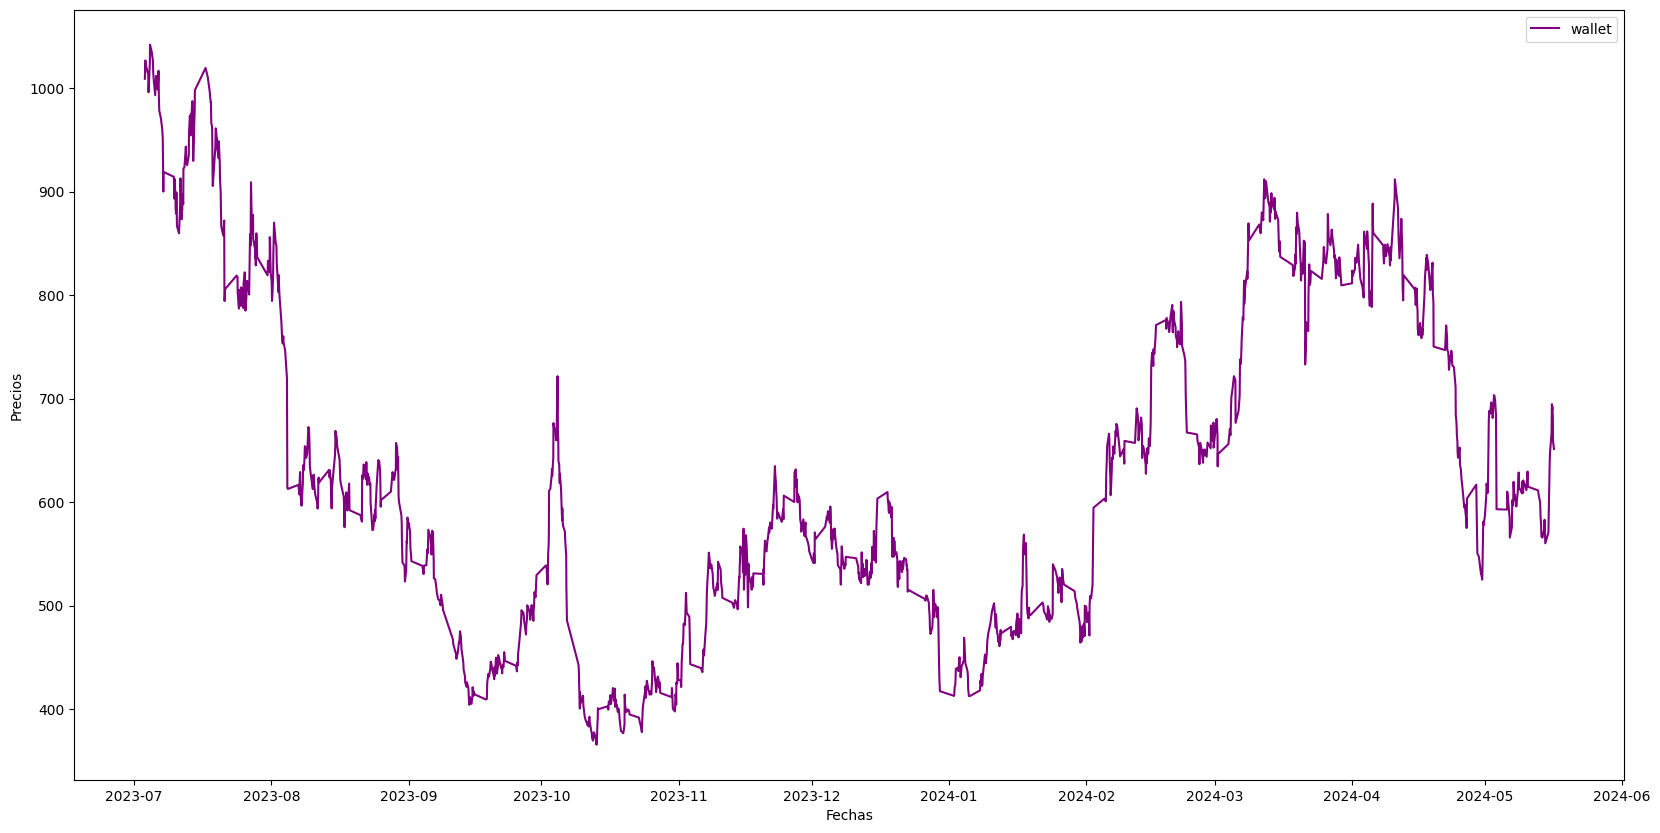

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
x_wallet = pd.to_datetime(wallet['date'])
y_wallet = wallet['wallet']  # Datos para la línea

# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Agregar la línea
ax.plot(x_wallet, y_wallet, label='wallet', color='purple')

# Etiquetas de los ejes y leyenda
ax.set_xlabel('Fechas')
ax.set_ylabel('Precios')
ax.legend()

# Mostrar el gráfico
plt.show()


# Grafico de velas

In [11]:
# import plotly.graph_objects as go

# fig = go.Figure(data=[go.Candlestick(x=prices['Date'],
#                 open=prices['Open'],
#                 high=prices['High'],
#                 low=prices['Low'],
#                 close=prices['Close'])])

# fig.update_layout(
#     title=f"{config['ticker']}",
#     yaxis_title=f"{config['ticker']} Stock"
# )

# fig.show()

# Estrategia

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
x_prices = pd.to_datetime(prices['Date'])
y_prices = prices['Close']  # Datos para la línea

x_buy = pd.to_datetime(buys['fecha'])
y_buy = buys['buy']  # Datos para el scatter plot

x_sell = pd.to_datetime(sells['date'])
y_sell = sells['sell']  # Datos para el scatter plot

x_wallet = pd.to_datetime(wallet['date'])
y_wallet = wallet['wallet']  # Datos para la línea

# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Agregar la línea
ax.plot(x_prices, y_prices, label='market', color='black')

ax.plot(x_wallet, y_wallet, label='wallet', color='purple')

# Agregar el scatter plot
ax.scatter(x_buy, y_buy, label='compras', color='cyan', marker='>')

ax.scatter(x_sell, y_sell, label='Ventas', color='red', marker='o')

# Etiquetas de los ejes y leyenda
ax.set_xlabel('Fechas')
ax.set_ylabel('Precios')
ax.legend()

# Mostrar el gráfico
plt.show()


NameError: name 'prices' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
x_prices = pd.to_datetime(prices['Date'])
y_prices = prices['Close']  # Datos para la línea

x_buy = pd.to_datetime(buys['date'])
y_buy = buys['buy']  # Datos para el scatter plot

x_sell = pd.to_datetime(sells['date'])
y_sell = sells['sell']  # Datos para el scatter plot

# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Agregar la línea
ax.plot(x_prices, y_prices, label='market', color='black')

# Agregar el scatter plot
ax.scatter(x_buy, y_buy, label='compras', color='cyan', marker='>')

ax.scatter(x_sell, y_sell, label='Ventas', color='red', marker='o')

# Etiquetas de los ejes y leyenda
ax.set_xlabel('Fechas')
ax.set_ylabel('Precios')
ax.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc

print('Area bajo la curva: ', auc(wallet.index, wallet['wallet']))

# Datos de ejemplo
x_prices = pd.to_datetime(wallet['date'])
y_prices = wallet['wallet']  # Datos para la línea


# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Agregar la línea
ax.plot(x_prices, y_prices, label='Wallet', color='blue')

# Etiquetas de los ejes y leyenda
ax.set_xlabel('Fechas')
ax.set_ylabel('Precios')
ax.legend()

# Mostrar el gráfico
plt.show()


# Modelo

In [ ]:
predictions.sort_values(by='fecha')

In [ ]:
true_values.sort_values(by='fecha')

In [ ]:
accuracy_score(predictions[predictions['YPF'].notna()].YPF, true_values[true_values['YPF'].notna()].YPF)

In [ ]:
threshold_down = 0.5
threshold_up = 0.5

df_predictions = performance[(performance['y_pred']<threshold_down) | (performance['y_pred']>threshold_up)].copy()
df_predictions['y_pred'] = np.where(df_predictions['y_pred']<threshold_down, 0, df_predictions['y_pred'])
df_predictions['y_pred'] = np.where(df_predictions['y_pred']>threshold_up, 1, df_predictions['y_pred'])

print(accuracy_score(df_predictions.y_true, df_predictions.y_pred))
plot_confusion_matrix(df_predictions.y_true, df_predictions.y_pred, classes=[0,1], cmap=plt.cm.Reds)

In [ ]:
threshold_down = 0.1
threshold_up = 0.9

df_predictions = performance[(performance['y_pred']<threshold_down) | (performance['y_pred']>threshold_up)].copy()
df_predictions['y_pred'] = np.where(df_predictions['y_pred']<threshold_down, 0, df_predictions['y_pred'])
df_predictions['y_pred'] = np.where(df_predictions['y_pred']>threshold_up, 1, df_predictions['y_pred'])

print(accuracy_score(df_predictions.y_true, df_predictions.y_pred))
plot_confusion_matrix(df_predictions.y_true, df_predictions.y_pred, classes=[0,1], cmap=plt.cm.Reds)

In [ ]:
plt.hist(performance.y_pred, color='lightgreen', ec='black', bins=50)
plt.show()

In [ ]:
buys = buys.rename(columns={''})

In [ ]:
operations = pd.concat([buys[buys['YPF'].notna()], sells[sells['YPF'].notna()]], axis=1, join="inner")[['fecha','YPF']]
operations

In [ ]:
operations['positive'] = np.where(operations['buy']>operations['sell'], 0, 1)
operations['Profit'] = operations['sell'] - operations['buy'] 
operations['positive'].value_counts()